In [10]:
import numpy as np
import scipy.linalg as sl
from enterprise.signals import (gp_signals, parameter, signal_base, utils,
                                white_signals)
from enterprise_extensions import blocks
from enterprise.signals import selections
import healpy as hp
import matplotlib.pyplot as plt

In [11]:
def get_xCy(Nvec, T, sigmainv, x, y):
    """Get x^T C^{-1} y"""
    TNx = Nvec.solve(x, left_array=T)
    TNy = Nvec.solve(y, left_array=T)
    xNy = Nvec.solve(y, left_array=x)
    return xNy - TNx @ sigmainv @ TNy


def get_TCy(Nvec, T, y, sigmainv, TNT):
    """Get T^T C^{-1} y"""
    TNy = Nvec.solve(y, left_array=T)
    return TNy - TNT @ sigmainv @ TNy


def innerprod(Nvec, T, sigmainv, TNT, x, y):
    """Get the inner product between x and y"""
    xCy = get_xCy(Nvec, T, sigmainv, x, y)
    TCy = get_TCy(Nvec, T, y, sigmainv, TNT)
    TCx = get_TCy(Nvec, T, x, sigmainv, TNT)
    return xCy - TCx.T @ sigmainv @ TCy

In [12]:
class FpStat(object):
    """
    Class for the Fp-statistic.

    :param psrs: List of `enterprise` Pulsar instances.
    :param noisedict: Dictionary of white noise parameter values. Default=None
    :param psrTerm: Include the pulsar term in the CW signal model. Default=True
    :param bayesephem: Include BayesEphem model. Default=True
    """

    def __init__(self, psrs, noisedict=None,
                 psrTerm=True, bayesephem=True, pta=None, tnequad=False, select=None):

        if pta is None:

            # initialize standard model with fixed white noise
            # and powerlaw red noise
            # uses the implementation of ECORR in gp_signals
            print('Initializing the model...')

            tmin_sec = np.min([p.toas.min() for p in psrs])
            tmax_sec = np.max([p.toas.max() for p in psrs])
            
            tmin_mjd = tmin_sec/3600/24
            tmax_mjd = tmax_sec/3600/24
            
            Tspan_sec = tmax_sec - tmin_sec
            s = gp_signals.TimingModel(use_svd=True)
            s += blocks.bwm_sglpsr_block(tmin_mjd, tmax_mjd, )
            if select is not None:
                s += blocks.white_noise_block(vary=False, inc_ecorr=False, gp_ecorr=False, select=select)
            else:
                noselect = selections.Selection(selections.no_selection)
                s += blocks.white_noise_block(vary=False, inc_ecorr=False, gp_ecorr=False, select=noselect)


            # adding white-noise, and acting on psr objects
            models = []
            for p in psrs:
                models.append(s(p))
            

            pta = signal_base.PTA(models)

            # set white noise parameters
            if noisedict is None:
                print('No noise dictionary provided!')
            else:
                pta.set_default_params(noisedict)

            self.pta = pta

        else:
            # user can specify their own pta object
            # if ECORR is included, use the implementation in gp_signals
            self.pta = pta

        self.psrs = psrs
        self.noisedict = noisedict

        # precompute important bits:
        self.phiinvs = self.pta.get_phiinv(noisedict)
        self.TNTs = self.pta.get_TNT(noisedict)
        self.Nvecs = self.pta.get_ndiag(noisedict)
        self.Ts = self.pta.get_basis(noisedict)
        # self.cf_TNT = [sl.cho_factor(TNT + np.diag(phiinv)) for TNT, phiinv in zip(self.TNTs, self.phiinvs)]
        self.sigmainvs = [np.linalg.pinv(TNT + np.diag(phiinv)) for TNT, phiinv in zip(self.TNTs, self.phiinvs)]

    def compute_Fp(self, fgw):
        """
        Computes the Fp-statistic.

        :param fgw: GW frequency

        :returns:
            fstat: value of the Fp-statistic at the given frequency

        """
        N = np.zeros(2)
        M = np.zeros((2, 2))
        fstat = 0
        for psr, Nvec, TNT, T, sigmainv in zip(self.psrs, self.Nvecs, self.TNTs, self.Ts, self.sigmainvs):

            ntoa = len(psr.toas)

            A = np.zeros((2, ntoa))
            A[0, :] = 1 / fgw ** (1 / 3) * np.sin(2 * np.pi * fgw * psr.toas)
            A[1, :] = 1 / fgw ** (1 / 3) * np.cos(2 * np.pi * fgw * psr.toas)

            ip1 = innerprod(Nvec, T, sigmainv, TNT, A[0, :], psr.residuals)
            # logger.info(ip1)
            ip2 = innerprod(Nvec, T, sigmainv, TNT, A[1, :], psr.residuals)
            # logger.info(ip2)
            N = np.array([ip1, ip2])

            # define M matrix M_ij=(A_i|A_j)
            for jj in range(2):
                for kk in range(2):
                    M[jj, kk] = innerprod(Nvec, T, sigmainv, TNT, A[jj, :], A[kk, :])

            # take inverse of M
            Minv = np.linalg.pinv(M)
            fstat += 0.5 * np.dot(N, np.dot(Minv, N))

        return fstat
    
    def compute_Fp_bwm(self, t0):
        """
        Computes the Fp statistic for GW memory
        
        :param t0: epoch of burst
        
        :returns:
            fstat: value of Fp-statistic for a memory signal at the given epoch
        """
        
        fstat = 0
        for psr, Nvec, TNT, T, sigmainv in zip(self.psrs, self.Nvecs, self.TNTs, self.Ts, self.sigmainvs):

            ntoa = len(psr.toas)

            A = np.zeros((1, ntoa))
            A[0, :] = np.heaviside(psr.toas - t0, 0) * (psr.toas - t0)
#             plt.scatter(psr.toas, A[0,:], )
#             plt.title("Template for BWM")
#             plt.show()
            

            N = innerprod(Nvec, T, sigmainv, TNT, A[0, :], psr.residuals)
#             print(ip1)
            # define M matrix, only one element for bwm

            M = innerprod(Nvec, T, sigmainv, TNT, A[0, :], A[0, :])
#             print(M)

            # take inverse of M
            Minv = 1/M
            fstat += 0.5 *N**2 * Minv
        return fstat
        

# Let's try this on one pulsr

In [5]:
import pickle
nano12p5_pkl = '/home/nima/nanograv/12p5yr_bwm/channelized_12yr_v3_partim_py3.pkl'
with open(nano12p5_pkl, 'rb') as pklin:
    allpsrs = pickle.load(pklin)
    
testpsr = allpsrs[0]
psrnames = [p.name for p in allpsrs[0:4]]

import json
nano12p5_wndict = '/home/nima/nanograv/12p5yr_bwm/wn_noisedict.json'
with open(nano12p5_wndict, 'rb') as wndict_in:
    noisedict = json.load(wndict_in)



In [6]:
noisedict

{'B1855+09_430_ASP_efac': 1.149036589204419,
 'B1855+09_430_ASP_log10_ecorr': -7.415374510054153,
 'B1855+09_430_ASP_log10_equad': -7.379759355541006,
 'B1855+09_430_PUPPI_efac': 1.0543836580555548,
 'B1855+09_430_PUPPI_log10_ecorr': -5.671108063699219,
 'B1855+09_430_PUPPI_log10_equad': -6.348065001180634,
 'B1855+09_L-wide_ASP_efac': 1.080749375878354,
 'B1855+09_L-wide_ASP_log10_ecorr': -6.092899143243734,
 'B1855+09_L-wide_ASP_log10_equad': -6.51289896375955,
 'B1855+09_L-wide_PUPPI_efac': 1.2429537099744354,
 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.641281263572077,
 'B1855+09_L-wide_PUPPI_log10_equad': -7.821737281350602,
 'B1937+21_L-wide_ASP_efac': 2.048754020884262,
 'B1937+21_L-wide_ASP_log10_ecorr': -6.940958996081342,
 'B1937+21_L-wide_ASP_log10_equad': -6.785369742733748,
 'B1937+21_L-wide_PUPPI_efac': 2.12041666470792,
 'B1937+21_L-wide_PUPPI_log10_ecorr': -7.037572450266321,
 'B1937+21_L-wide_PUPPI_log10_equad': -7.147037241326325,
 'B1937+21_Rcvr1_2_GASP_efac': 1.1708200

### let's run fp

In [108]:
fpstat_test = FpStat(allpsrs[0:1], psrTerm=False, noisedict=noisedict)

Initializing the model...


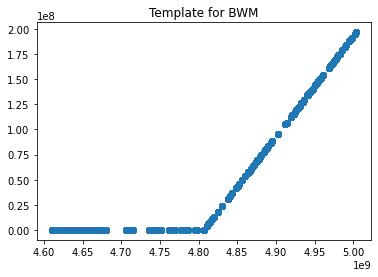

21.659479368316816


In [110]:
test_toas = []
test_toas.append((testpsr.toas.min() + testpsr.toas.max())/2)
fstat = fpstat_test.compute_Fp_bwm(t0 = test_toas[0])
print(2* fstat)

It seems to be working! Let's try on some realizations of WN only data sets we've made

In [7]:
# We know the injected WN values
fake_noisedict = {}
for psrname in psrnames:
    fake_noisedict['{}_efac'.format(psrname)] = 1.0
    fake_noisedict['{}_log10_equad'.format(psrname)] = np.log10(100e-9)

In [18]:
from enterprise.pulsar import Pulsar


partim_dir = '/home/nima/nanograv/bwm_fpfe/sandbox/'

burst_epoch = (53000 + 365.25*6) * 24*3600
for realization in range(201, 800):
    realization_psrs = []
    for psrname in psrnames:
        parfile = partim_dir + '/WN_4psr_sims_LT_{}/{}_fake.par'.format(realization, psrname)
        timfile = partim_dir + '/WN_4psr_sims_LT_{}/{}_fake.tim'.format(realization, psrname)
        
        realization_psrs.append(Pulsar(parfile,timfile))
    realization_FpStat = FpStat(realization_psrs,noisedict=fake_noisedict)
    fps.append(realization_FpStat.compute_Fp_bwm(t0 = burst_epoch))
    

Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


Initializing the model...


In [19]:
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy.stats as stats
def chisq(x, k = 2):
    prefactor = 1/(2**(k/2) * gamma(k/2))
    postfactor = x**(k/2 - 1) * np.exp(-x/2)
    
    return prefactor*postfactor

def nc_chisq_wrapper(x, dof, nc):
    return stats.ncx2.pdf(x, dof, nc, loc=0, scale=1)

In [43]:
twofps = [2* f for f in fps]
print(fps[0])
print(twofps[0])

2.4861273715013894
4.972254743002779


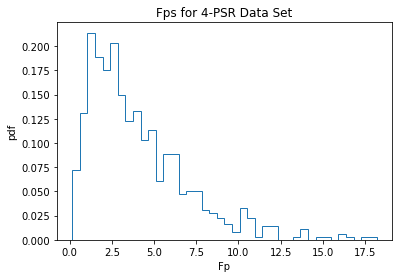

In [44]:
n, bins, patches = plt.hist(twofps, bins=40, histtype='step', density=True)
plt.title("Fps for 4-PSR Data Set")
plt.xlabel("Fp")
plt.ylabel("pdf")
midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
counts = n

In [45]:
popt, pcov = curve_fit(nc_chisq_wrapper,midpts, counts)

Text(0, 0.5, 'pdf')

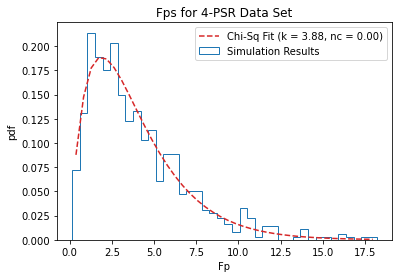

In [46]:
n, bins, patches = plt.hist(twofps, bins=40, histtype='step', density=True, label='Simulation Results')
fitted = []
for pt in midpts:
    fitted.append(nc_chisq_wrapper(pt, dof=popt[0], nc=popt[1]))
plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(popt[0], popt[1]))
plt.title("Fps for 4-PSR Data Set")
plt.legend()
plt.xlabel("Fp")
plt.ylabel("pdf")